In [1]:
from math import ceil
from accelerate import Accelerator
from loader.chaotic_rnn_loader import *
from utils.utils import set_seed, dummy_load, move_batch_to_device
from utils.config_utils import config_from_kwargs, update_config
from models.ndt1_with_region_stitcher import NDT1_with_region_stitcher 
import torch
import numpy as np
import os
from utils.eval_utils_rnn import load_model_data_local
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#from loader.rnn_data_loader import *

In [2]:
eids = [0,1,2]
base_path = '/mnt/smb/locker/miller-locker/users/jx2484/results'
model_acroynm ='ndt1_with_region_stitcher'
num_train_sessions = 3

In [3]:
model_name = 'NDT1_with_region_stitcher'
mask_name = 'mask_inter-region'

model_config = f"/mnt/smb/locker/miller-locker/users/jx2484/code/autoencoder/src/configs/{model_acroynm}_stitching_eval.yaml"

configs = {
    'region_channel_num': 50,
    'model_config': model_config,
    'model_path': f'{base_path}/finetune/num_session_{num_train_sessions}/model_{model_name}/method_ssl/{mask_name}/stitch_True/{eids}/region_factors_50/model_best.pt',
    'trainer_config': f'/mnt/smb/locker/miller-locker/users/jx2484/code/autoencoder/src/configs/finetune_sessions_trainer.yaml',
    'dataset_path': None, 
    'test_size': 0.2,
    'seed': 42,
    'mask_name': mask_name,
    'eids': eids,
    'stitching': True,
    'num_sessions': 1 
}  
        

In [4]:
set_seed(42)

max_space_length = 600
meta_data = {}
meta_data['max_space_length'] = max_space_length
print('encoder max space length:', max_space_length)

#dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list = make_loader(eids, batch_size=12) # for test, the batch size is the total number of trials 
#dataloader, num_neurons, datasets, area_ind_list_list, record_info_list = make_rnn_loader(eids, batch_size=12)
dataloader, num_neurons, datasets, area_ind_list_list, record_info_list = make_chaotic_rnn_loader(eids, batch_size=12)


seed set to 42
encoder max space length: 600
num_neurons:  [113, 111, 102]
num_trials:  {'train': [156, 135, 137], 'val': [52, 45, 46], 'test': [52, 46, 46]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test


In [5]:
areaoi_ind = np.array([0,1,2])
meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind

meta_data['num_neurons'] = num_neurons
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = eids

train_dataloader = dataloader['train']
val_dataloader = dataloader['val']
test_dataloader = dataloader['test']

In [6]:
# load your model and dataloader
model, accelerator = load_model_data_local(meta_data, **configs)


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


seed set to 42


/mnt/smb/locker/miller-locker/users/jx2484/code/autoencoder/src/utils/eval_utils_rnn.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)['mod

(eval) masking mode:  inter-region
(eval) masking ratio:  0.3
(eval) masking active:  False


In [7]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

/home/jx2484/.conda/envs/svo-ae/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
/home/jx2484/.conda/envs/svo-ae/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/jx2484/.conda/envs/svo-ae/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
/home/jx2484/.conda/envs/svo-ae/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In

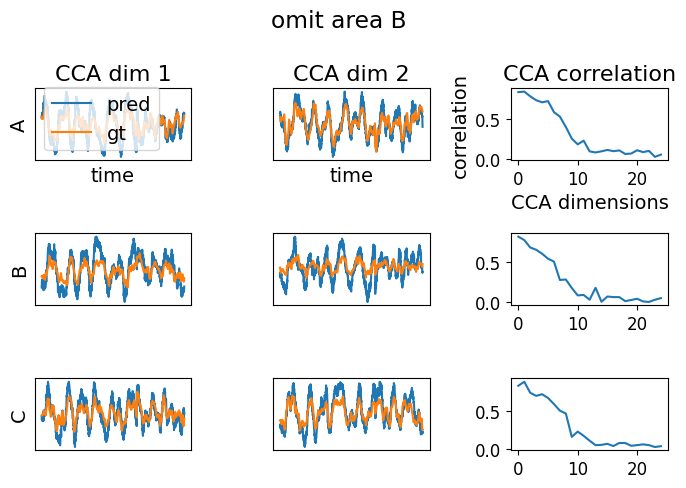

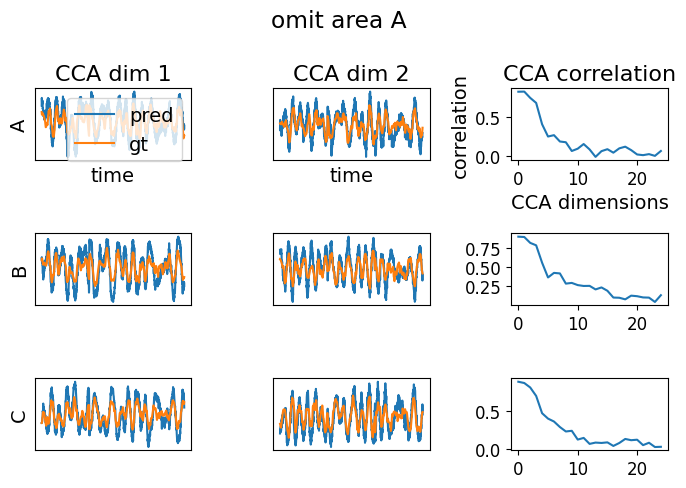

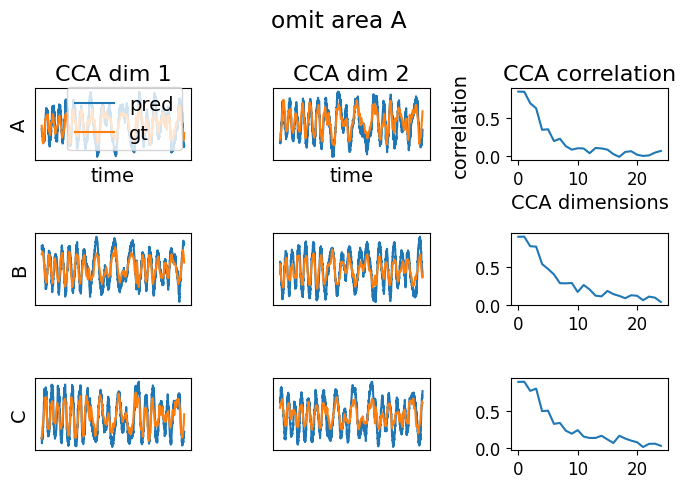

In [18]:
model.eval()
n_factors = 200
region_channel_num = 50

for eid_eval in eids:
    eid_ind = eids.index(eid_eval)
    record_info = record_info_list[eid_ind]
    omit_region = record_info['omit_region'] #int
    n_region = record_info['gt_n'] #list of 3 int
    tmp_accum = np.cumsum([0] + n_region)
    neuron_id_record = list(np.arange(0, tmp_accum[omit_region])) + list(np.arange(tmp_accum[omit_region+1], tmp_accum[-1]))

    with torch.no_grad():
        for batch in test_dataloader:
            eid_tmp = batch['eid'].unique().item()
            if eid_tmp != eid_eval:
                continue

            batch = move_batch_to_device(batch, accelerator.device)
            
            
            spikes = batch['spikes_data']
            time_attn_mask=batch['time_attn_mask']
            space_attn_mask=batch['space_attn_mask']
            spikes_timestamps=batch['spikes_timestamps'] 
            spikes_spacestamps=batch['spikes_spacestamps'] 
            targets = batch['target']
            neuron_regions=batch['neuron_regions']
            num_neuron=batch['spikes_data'].shape[2]
            eid=batch['eid'][0]  # each batch consists of data from the same eid

            block_idx = None
            date_idx = None
            masking_mode = None
            eval_mask = None
            spikes_lengths = None    

            x, new_mask = model.encoder(spikes, time_attn_mask, spikes_timestamps, block_idx, date_idx, neuron_regions, masking_mode, eval_mask, num_neuron, eid)
            
            factors_pred = model.stitch_decoder.Linear(x)
            #outputs = model.stitch_decoder(x, str(eid.item()), neuron_regions)
            #fr_gt = batch['fr'][:,:,neuron_id_record].clone()
            factors_gt = batch['factors'].clone()

            # flatten factors
            factors_pred_flat = factors_pred.reshape(-1, factors_pred.shape[-1])
            factors_gt_flat = factors_gt.reshape(-1, factors_gt.shape[-1])

            factors_pred_flat = factors_pred_flat.cpu().numpy()
            factors_gt_flat = factors_gt_flat.cpu().numpy()

            # perform CCA on the factors
            from sklearn.cross_decomposition import CCA
            cca_A = CCA(n_components=25)
            pred_A = factors_pred_flat[:,:region_channel_num]
            gt_A = factors_gt_flat[:,:n_factors]

            # #reduce the dimension of the gt_A with PCA
            # from sklearn.decomposition import PCA
            # pca = PCA(n_components=25)
            # gt_A = pca.fit_transform(gt_A)

            cca_A.fit(pred_A[:400*15], gt_A[:400*15])
            X_A, Y_A = cca_A.transform(pred_A[400*15:], gt_A[400*15:])
            cc_A = [np.corrcoef(X_A[:, i], Y_A[:, i])[0, 1] for i in range(X_A.shape[1])]

            cca_B = CCA(n_components=25)
            pred_B = factors_pred_flat[:,region_channel_num:2*region_channel_num]
            gt_B = factors_gt_flat[:,n_factors:2*n_factors]


            cca_B.fit(pred_B[:400*15], gt_B[:400*15])
            X_B, Y_B = cca_B.transform(pred_B[400*15:], gt_B[400*15:])
            cc_B = [np.corrcoef(X_B[:, i], Y_B[:, i])[0, 1] for i in range(X_B.shape[1])]



            cca_C = CCA(n_components=25)
            pred_C = factors_pred_flat[:,2*region_channel_num:3*region_channel_num]
            gt_C = factors_gt_flat[:,2*n_factors:3*n_factors]

            cca_C.fit(pred_C[:400*15], gt_C[:400*15])
            X_C, Y_C = cca_C.transform(pred_C[400*15:], gt_C[400*15:])
            cc_C = [np.corrcoef(X_C[:, i], Y_C[:, i])[0, 1] for i in range(X_C.shape[1])]

            break
        
    T = 400*3

    fig, ax = plt.subplots(3,3, figsize=(7,5))
    X_list = [X_A, X_B, X_C]
    Y_list = [Y_A, Y_B, Y_C]
    cc_list = [cc_A, cc_B, cc_C]    
    area_name = ['A', 'B', 'C']

    for i in range(3):
        plt.sca(ax[i,0])
        plt.plot(X_list[i][:T,0], label='pred')
        plt.plot(Y_list[i][:T,0], label='gt')
        plt.ylabel(area_name[i])
        plt.yticks([])
        plt.xticks([])
        plt.sca(ax[i,1])
        plt.plot(X_list[i][:T,1])
        plt.plot(Y_list[i][:T,1])
        plt.yticks([])
        plt.xticks([])
        plt.sca(ax[i,2])
        plt.plot(cc_list[i])  

    plt.sca(ax[0,0])
    plt.title('CCA dim 1')
    plt.xlabel('time')
    plt.legend()

    plt.sca(ax[0,1])
    plt.title('CCA dim 2')
    plt.xlabel('time')

    plt.sca(ax[0,2])
    plt.title('CCA correlation')
    plt.xlabel('CCA dimensions')
    plt.ylabel('correlation')
    
    plt.suptitle('omit area ' + area_name[record_info['omit_region']])
    plt.tight_layout()

            

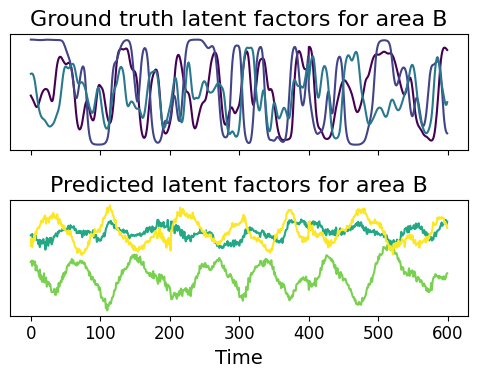

In [15]:
f, a = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

# Create a colormap
cmap = plt.get_cmap('viridis')
# Select colors from the colormap
colors = [cmap(i) for i in np.linspace(0, 1, 6)]


# Specify colors for each line
colors_gt = colors[:3]
plt.sca(a[0])
# Use a for loop to plot each line with its corresponding color
for i in range(3):
    plt.plot(factors_gt_flat[:120*5, n_factors+i], color=colors_gt[i])
plt.yticks([])
plt.title('Ground truth latent factors for area B')

# Specify colors for each line
colors_pred = colors[3:]

plt.sca(a[1])
# Use a for loop to plot each line with its corresponding color
for i in range(3):
    plt.plot(factors_pred_flat[:120*5, region_channel_num+i], color=colors_pred[i])
plt.yticks([])
plt.xlabel('Time')
plt.title('Predicted latent factors for area B')

plt.tight_layout()
#plt.savefig('latent_factor_B.pdf', transparent=True)


Text(0.5, 0, 'Time')

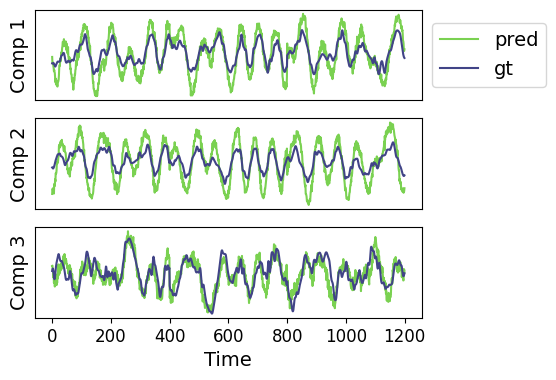

In [16]:
plt.figure(figsize=(5, 4))
plt.subplot(311)
plt.plot(X_B[:T,0],color=colors[4], label='pred')
plt.plot(Y_B[:T,0],color=colors[1], label='gt')
plt.ylabel('Comp 1')

#put legend outside
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.yticks([])
plt.xticks([])
plt.subplot(312)
plt.plot(X_B[:T,1],color=colors[4])
plt.plot(Y_B[:T,1],color=colors[1])
plt.yticks([])
plt.xticks([])
plt.ylabel('Comp 2')
plt.subplot(313)
plt.plot(X_B[:T,2], color=colors[4])
plt.plot(Y_B[:T,2], color=colors[1])
plt.yticks([])
plt.ylabel('Comp 3')
plt.xlabel('Time')
#plt.savefig('cca_B.pdf', transparent=True)